In [1]:
%matplotlib inline  
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors.kde import KernelDensity
from scipy.stats.distributions import norm
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from pprint import pprint
from functools import partial
from sklearn.decomposition import PCA
from __future__ import division
from scipy.spatial.distance import cdist
from scipy.sparse import issparse
from time import time

import matplotlib.pyplot as plt
import arff
import pandas as pd
import numpy as np
import random
import sys
 

In [2]:
def kmeans( X, centres, delta=.001, maxiter=10, metric="euclidean", p=2, verbose=1 ):
    if not issparse(X):
        X = np.asanyarray(X)  # ?
    centres = centres.todense() if issparse(centres) \
        else centres.copy()
    N, dim = X.shape
    k, cdim = centres.shape
    if dim != cdim:
        raise ValueError( "kmeans: X %s and centres %s must have the same number of columns" % (
            X.shape, centres.shape ))
    allx = np.arange(N)
    prevdist = 0
    for jiter in range( 1, maxiter+1 ):
        D = cdist_sparse( X, centres, metric=metric, p=p )  # |X| x |centres|
        xtoc = D.argmin(axis=1)  # X -> nearest centre
        distances = D[allx,xtoc]
        avdist = distances.mean()  # median ?
        if (1 - delta) * prevdist <= avdist <= prevdist \
        or jiter == maxiter:
            break
        prevdist = avdist
        for jc in range(k):  # (1 pass in C)
            c = np.where( xtoc == jc )[0]
            if len(c) > 0:
                centres[jc] = X[c].mean( axis=0 )
    return centres, xtoc, distances

def kmeanssample( X, k, nsample=0, **kwargs ):
    N, dim = X.shape
    if nsample == 0:
        nsample = max( 2*np.sqrt(N), 10*k )
    Xsample = randomsample(X, int(nsample))
    pass1centres = randomsample( X, int(k) )
    samplecentres = kmeans( Xsample, pass1centres, **kwargs )[0]
    return kmeans( X, samplecentres, **kwargs )

def cdist_sparse( X, Y, **kwargs ):
    sxy = 2*issparse(X) + issparse(Y)
    if sxy == 0:
        return cdist( X, Y, **kwargs )
    d = np.empty( (X.shape[0], Y.shape[0]), np.float64 )
    if sxy == 2:
        for j, x in enumerate(X):
            d[j] = cdist( x.todense(), Y, **kwargs ) [0]
    elif sxy == 1:
        for k, y in enumerate(Y):
            d[:,k] = cdist( X, y.todense(), **kwargs ) [0]
    else:
        for j, x in enumerate(X):
            for k, y in enumerate(Y):
                d[j,k] = cdist( x.todense(), y.todense(), **kwargs ) [0]
    return d

def randomsample( X, n ):
    sampleix = random.sample(range( X.shape[0] ), int(n) )
    return X[sampleix]

def nearestcentres( X, centres, metric="euclidean", p=2 ):
    D = cdist( X, centres, metric=metric, p=p )
    return D.argmin(axis=1)

def Lqmetric( x, y=None, q=.5 ):
    return (np.abs(x - y) ** q) .mean() if y is not None \
        else (np.abs(x) ** q) .mean()

class Kmeans:
    def __init__( self, X, k=0, centres=None, nsample=0, **kwargs ):
        self.X = X
        if centres is None:
            self.centres, self.Xtocentre, self.distances = kmeanssample(
                X, k=k, nsample=nsample, **kwargs )
        else:
            self.centres, self.Xtocentre, self.distances = kmeans(
                X, centres, **kwargs )

    def __iter__(self):
        for jc in range(len(self.centres)):
            yield jc, (self.Xtocentre == jc)

In [3]:
def eval_kmeans(df, visualizer, n_clust):
    metric_names = ["cityblock", "euclidean", "chebyshev"]
    for metric_name in metric_names:
        dim = 10
        X = df.drop('class', axis=1)
        kmsample = 100
        kmdelta = .001
        kmiter = 10
        seed = 1
        
        Z = X.as_matrix()
        for n_clusters in n_clust:
            np.set_printoptions( 1, threshold=200, edgeitems=5, suppress=True )
            np.random.seed(seed)
            random.seed(seed)

            t0 = time()
            if kmsample > 0:
                centres, xtoc, dist = kmeanssample(Z, n_clusters, nsample=kmsample, delta=kmdelta, maxiter=kmiter, metric=metric_name, verbose=2)
            else:
                randomcentres = randomsample( Z, ncluster )
                centres, xtoc, dist = kmeans( Z, randomcentres,
                    delta=kmdelta, maxiter=kmiter, metric=metric, verbose=2 )

            core_samples_mask = np.zeros_like(xtoc, dtype=bool)
            labels = xtoc
            print(metric_name)
            clustering_summary(df['class'], labels, visualizer)
            print('')

In [33]:
def visualize_atom(df, labels):
    fig = pyplot.figure()
    ax = Axes3D(fig)

    ax.scatter(df['x'], df['y'], df['z'], c=labels)
    pyplot.show()
    
def visualze_vehicle(df, labels):
    pca = PCA(n_components=2)
    reduced_dim_data = pca.fit_transform(df.drop('class', axis=1))
    class_group = pd.DataFrame(
        {
            'x': reduced_dim_data[:, 0], 
            'y': reduced_dim_data[:, 1],
            'class': labels
        }
    ).groupby('class')

    fig, ax = plt.subplots()
    for name, group in class_group:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
    ax.legend()

    plt.show()
    
def visualze_cluto(df, labels):
    class_group = pd.DataFrame(
        {
            'x': df['x'], 
            'y': df['y'],
            'class': labels
        }
    ).groupby('class')

    fig, ax = plt.subplots()
    for name, group in class_group:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
    ax.legend()

    plt.show()

In [34]:
path_visual = {
    'data/atom.arff': visualize_atom,
    'data/vehicle.arff': visualze_vehicle,
    'data/cluto-t7-10k.arff': visualze_cluto
}
PATH_N_CLUST = {
    'data/atom.arff': [2],
    'data/vehicle.arff': [4],
    'data/cluto-t7-10k.arff': [10]
}

In [35]:
def get_df(arff_path):
    dataset = arff.load(open(arff_path, 'r'))
    print(dataset['attributes'])
    attributes = [a[0].lower() for a in dataset['attributes']]
    return pd.DataFrame(dataset['data'], columns=attributes)

In [36]:
def clustering_summary(classes, labels, visual_partial):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    result = {
        'est_number_of_clusters': n_clusters,
        'homogenity': metrics.homogeneity_score(classes, labels),
        'completeness': metrics.completeness_score(classes, labels),
        'v_measure': metrics.v_measure_score(classes, labels),
        'adjusted_rand_score': metrics.adjusted_rand_score(classes, labels),
        'adjusted_mutual_info_score': metrics.adjusted_mutual_info_score(classes, labels)
    }
    pprint(result)
    
    visual_partial(labels)
    
    return result
###partial(visualizer, df)

In [37]:
def eval_dbscan(df, visualizer):
    # http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
    metric_names = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    for metric_name in metric_names:
        db = DBSCAN(eps=10, min_samples=10, metric=metric_name, p=2).fit(df.drop('class', axis=1))
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        print(metric_name)
        clustering_summary(df['class'], labels, visualizer)
        print('')


In [38]:
def eval_agglomerative(df, visualizer, n_clust):
    metrics_agglomerative = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2']
    for metric_agglomerative  in metrics_agglomerative:
        for n_clusters in n_clust:
            for linkage in ('average', 'complete'):
                model = AgglomerativeClustering(linkage=linkage,
                                                affinity=metric_agglomerative,
                                                connectivity=None,
                                                n_clusters=n_clusters)
                model.fit(df.drop('class', axis=1))
                core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
                labels = model.labels_

                print(metric_agglomerative)
                print("linkage: {}".format(linkage))
                clustering_summary(df['class'], labels, visualizer)
                print('')


data/cluto-t7-10k.arff <function visualze_cluto at 0x7fc9b8d5dd08>
[('x', 'REAL'), ('y', 'REAL'), ('CLASS', ['0', '1', '2', '3', '4', '5', '6', '7', '8', 'noise'])]
=== ground truth ===


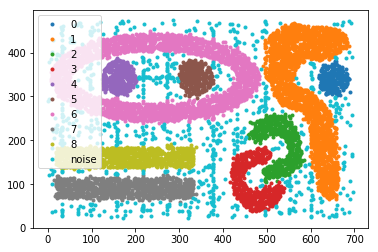

=== dbscan ===
euclidean
{'adjusted_mutual_info_score': 0.87178427850639917,
 'adjusted_rand_score': 0.87233741866174941,
 'completeness': 0.96114827829870753,
 'est_number_of_clusters': 9,
 'homogenity': 0.87204533731971234,
 'v_measure': 0.91443136984797524}


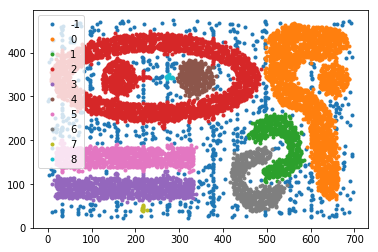


manhattan
{'adjusted_mutual_info_score': 0.94569269663706701,
 'adjusted_rand_score': 0.96755052976089395,
 'completeness': 0.94584986623514566,
 'est_number_of_clusters': 13,
 'homogenity': 0.95740833857833685,
 'v_measure': 0.95159400515021286}


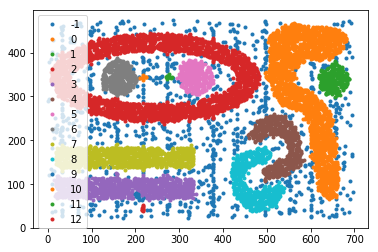


chebyshev
{'adjusted_mutual_info_score': 0.69273639166271994,
 'adjusted_rand_score': 0.72146192029609468,
 'completeness': 0.94175807344716977,
 'est_number_of_clusters': 7,
 'homogenity': 0.69322866096669133,
 'v_measure': 0.79860426322590194}


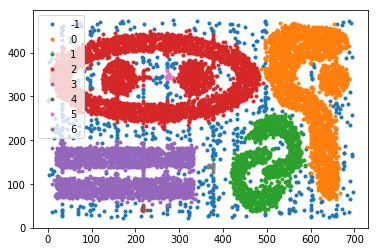


minkowski
{'adjusted_mutual_info_score': 0.87178427850639917,
 'adjusted_rand_score': 0.87233741866174941,
 'completeness': 0.96114827829870753,
 'est_number_of_clusters': 9,
 'homogenity': 0.87204533731971234,
 'v_measure': 0.91443136984797524}


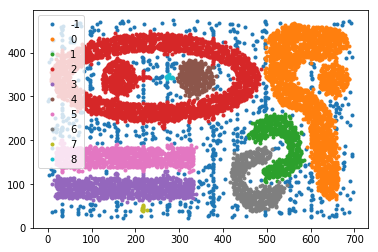


=== agglomerative ===
euclidean
linkage: average
{'adjusted_mutual_info_score': 0.60020980767408683,
 'adjusted_rand_score': 0.41586432537512874,
 'completeness': 0.60094714022657747,
 'est_number_of_clusters': 10,
 'homogenity': 0.65400075526281787,
 'v_measure': 0.62635251231358124}


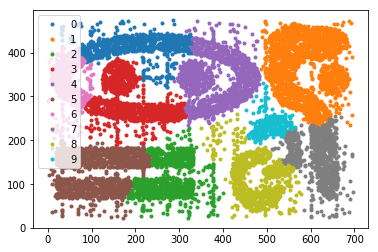


euclidean
linkage: complete
{'adjusted_mutual_info_score': 0.51417132768161389,
 'adjusted_rand_score': 0.33364328139232846,
 'completeness': 0.51506045190893912,
 'est_number_of_clusters': 10,
 'homogenity': 0.56465066864835523,
 'v_measure': 0.53871674196445174}


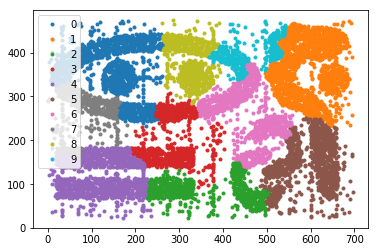


manhattan
linkage: average
{'adjusted_mutual_info_score': 0.58883838479105521,
 'adjusted_rand_score': 0.38685333877799294,
 'completeness': 0.58958653872094424,
 'est_number_of_clusters': 10,
 'homogenity': 0.6500411902449752,
 'v_measure': 0.61833972639880241}


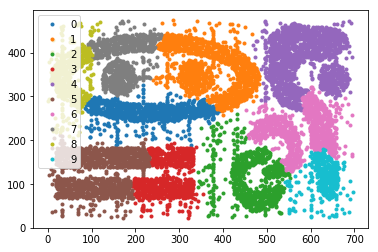


manhattan
linkage: complete
{'adjusted_mutual_info_score': 0.49829873065969932,
 'adjusted_rand_score': 0.2790143297820189,
 'completeness': 0.49922088989899527,
 'est_number_of_clusters': 10,
 'homogenity': 0.54500298531076863,
 'v_measure': 0.52110832127793694}


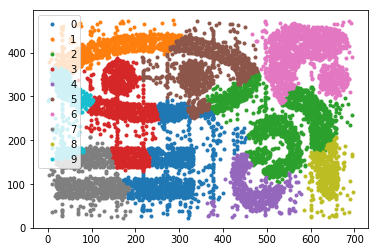


cosine
linkage: average
{'adjusted_mutual_info_score': 0.29029948091025048,
 'adjusted_rand_score': 0.13608349966430244,
 'completeness': 0.2916311568209905,
 'est_number_of_clusters': 10,
 'homogenity': 0.31205158670805933,
 'v_measure': 0.30149599668030852}


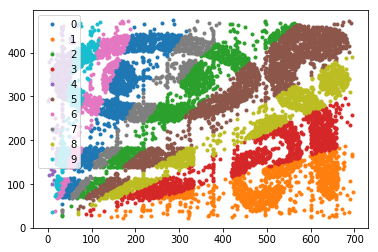


cosine
linkage: complete
{'adjusted_mutual_info_score': 0.30897960549336628,
 'adjusted_rand_score': 0.13985758892442646,
 'completeness': 0.31028275386273457,
 'est_number_of_clusters': 10,
 'homogenity': 0.33041606375736465,
 'v_measure': 0.32003307439818129}


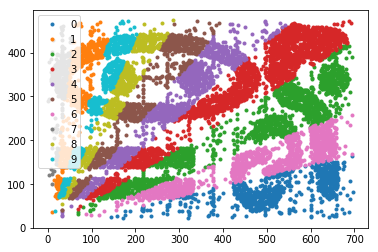


l1
linkage: average
{'adjusted_mutual_info_score': 0.58883838479105521,
 'adjusted_rand_score': 0.38685333877799294,
 'completeness': 0.58958653872094424,
 'est_number_of_clusters': 10,
 'homogenity': 0.6500411902449752,
 'v_measure': 0.61833972639880241}


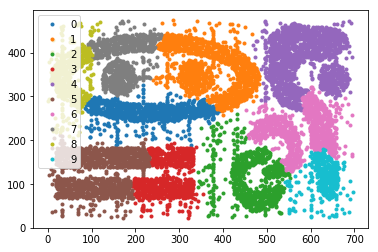


l1
linkage: complete
{'adjusted_mutual_info_score': 0.49829873065969932,
 'adjusted_rand_score': 0.2790143297820189,
 'completeness': 0.49922088989899527,
 'est_number_of_clusters': 10,
 'homogenity': 0.54500298531076863,
 'v_measure': 0.52110832127793694}


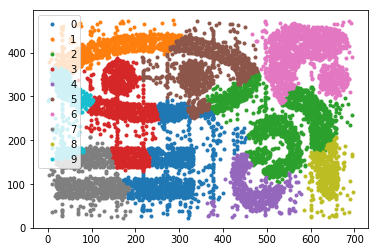


l2
linkage: average
{'adjusted_mutual_info_score': 0.60020980767408683,
 'adjusted_rand_score': 0.41586432537512874,
 'completeness': 0.60094714022657747,
 'est_number_of_clusters': 10,
 'homogenity': 0.65400075526281787,
 'v_measure': 0.62635251231358124}


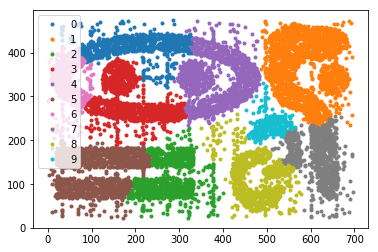


l2
linkage: complete
{'adjusted_mutual_info_score': 0.51417132768161389,
 'adjusted_rand_score': 0.33364328139232846,
 'completeness': 0.51506045190893912,
 'est_number_of_clusters': 10,
 'homogenity': 0.56465066864835523,
 'v_measure': 0.53871674196445174}


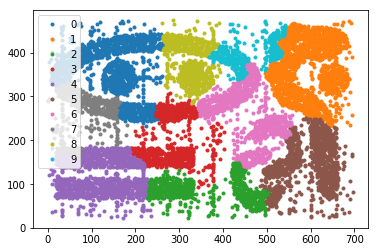


=== kmeans ===
cityblock
{'adjusted_mutual_info_score': 0.53525721831803574,
 'adjusted_rand_score': 0.32750971715655824,
 'completeness': 0.53608264000881234,
 'est_number_of_clusters': 10,
 'homogenity': 0.60522087647488521,
 'v_measure': 0.5685576195343971}


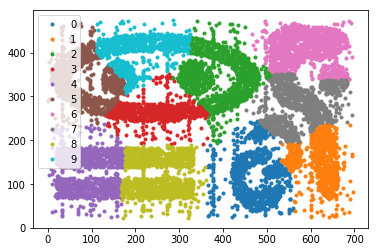


euclidean
{'adjusted_mutual_info_score': 0.54211461549234952,
 'adjusted_rand_score': 0.3382281759753018,
 'completeness': 0.54293080854357578,
 'est_number_of_clusters': 10,
 'homogenity': 0.61077781160208766,
 'v_measure': 0.57485934542420125}


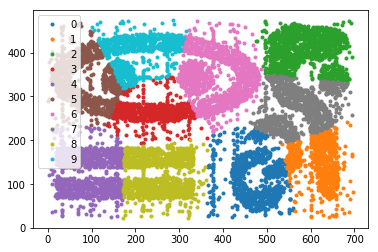


chebyshev
{'adjusted_mutual_info_score': 0.54912741419374966,
 'adjusted_rand_score': 0.35855404208874053,
 'completeness': 0.54993640509969077,
 'est_number_of_clusters': 10,
 'homogenity': 0.61465601221091326,
 'v_measure': 0.58049788527522028}


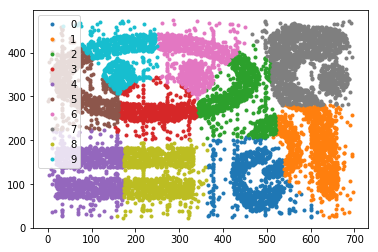


data/atom.arff <function visualize_atom at 0x7fc9bd2997b8>
[('x', 'REAL'), ('y', 'REAL'), ('z', 'REAL'), ('class', ['1', '2'])]
=== ground truth ===


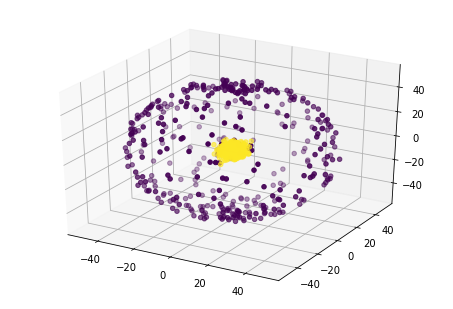

=== dbscan ===
euclidean
{'adjusted_mutual_info_score': 0.65835603277722587,
 'adjusted_rand_score': 0.80290477651631387,
 'completeness': 0.65896983759490024,
 'est_number_of_clusters': 3,
 'homogenity': 0.99999999999999933,
 'v_measure': 0.79443257214398166}


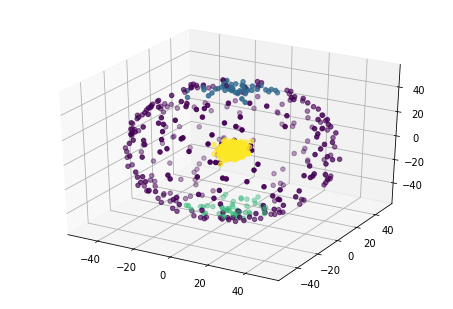


manhattan
{'adjusted_mutual_info_score': 0.70306853280297155,
 'adjusted_rand_score': 0.84784939200242937,
 'completeness': 0.703639786890631,
 'est_number_of_clusters': 3,
 'homogenity': 1.0,
 'v_measure': 0.82604291388952256}


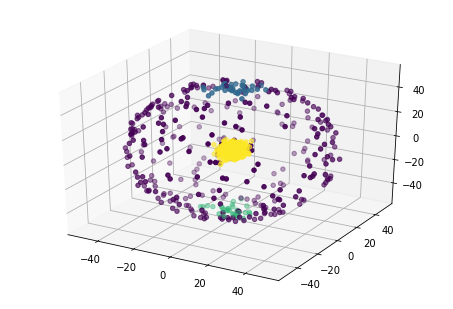


chebyshev
{'adjusted_mutual_info_score': 0.45924419848308096,
 'adjusted_rand_score': 0.64092073941893313,
 'completeness': 0.46133763942229994,
 'est_number_of_clusters': 9,
 'homogenity': 1.0,
 'v_measure': 0.63139089417374783}


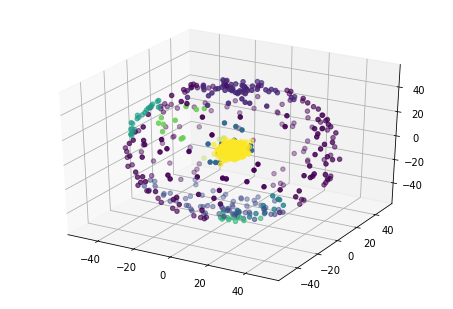


minkowski
{'adjusted_mutual_info_score': 0.65835603277722587,
 'adjusted_rand_score': 0.80290477651631387,
 'completeness': 0.65896983759490024,
 'est_number_of_clusters': 3,
 'homogenity': 0.99999999999999933,
 'v_measure': 0.79443257214398166}


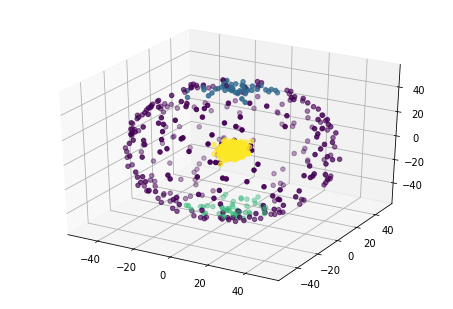


=== agglomerative ===
euclidean
linkage: average
{'adjusted_mutual_info_score': 0.17812042492975286,
 'adjusted_rand_score': 0.098626218186430442,
 'completeness': 0.28468240902897579,
 'est_number_of_clusters': 2,
 'homogenity': 0.17886455515562594,
 'v_measure': 0.21969550611196156}


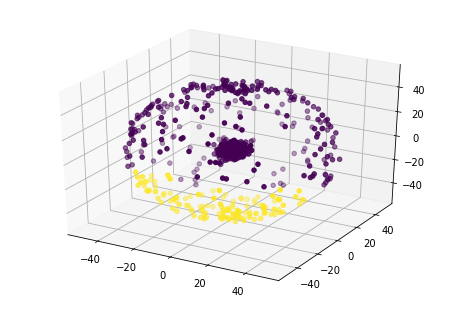


euclidean
linkage: complete
{'adjusted_mutual_info_score': 0.16206550003261144,
 'adjusted_rand_score': 0.08353119288930394,
 'completeness': 0.27265321423929345,
 'est_number_of_clusters': 2,
 'homogenity': 0.16282442208408213,
 'v_measure': 0.20388923946906878}


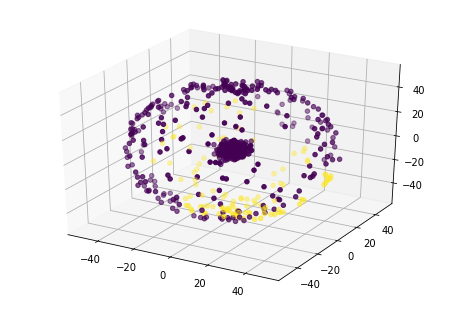


manhattan
linkage: average
{'adjusted_mutual_info_score': 0.1131017789735359,
 'adjusted_rand_score': 0.043650072668731214,
 'completeness': 0.23502919838009639,
 'est_number_of_clusters': 2,
 'homogenity': 0.11390636976580711,
 'v_measure': 0.15344565140605193}


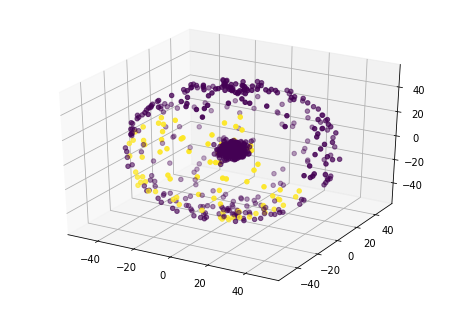


manhattan
linkage: complete
{'adjusted_mutual_info_score': 0.15889971446655077,
 'adjusted_rand_score': 0.080662610597615592,
 'completeness': 0.27026978951031772,
 'est_number_of_clusters': 2,
 'homogenity': 0.15966156079245025,
 'v_measure': 0.20073761263455603}


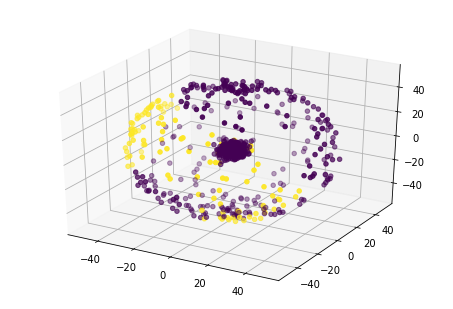


cosine
linkage: average
{'adjusted_mutual_info_score': -0.00043217169586058928,
 'adjusted_rand_score': -0.00057205485260781346,
 'completeness': 0.00048732086914683411,
 'est_number_of_clusters': 2,
 'homogenity': 0.00047170249634536753,
 'v_measure': 0.00047938450463045587}


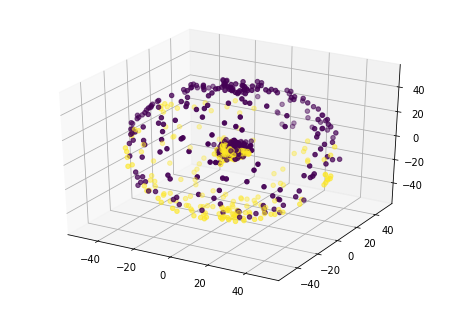


cosine
linkage: complete
{'adjusted_mutual_info_score': 0.0026515734241125575,
 'adjusted_rand_score': 0.0036582826362855101,
 'completeness': 0.0035634344119209078,
 'est_number_of_clusters': 2,
 'homogenity': 0.0035525664964486774,
 'v_measure': 0.0035579921551704844}


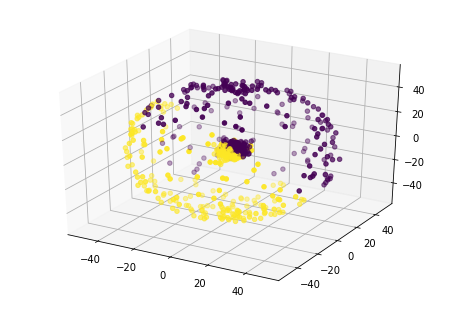


l1
linkage: average
{'adjusted_mutual_info_score': 0.1131017789735359,
 'adjusted_rand_score': 0.043650072668731214,
 'completeness': 0.23502919838009639,
 'est_number_of_clusters': 2,
 'homogenity': 0.11390636976580711,
 'v_measure': 0.15344565140605193}


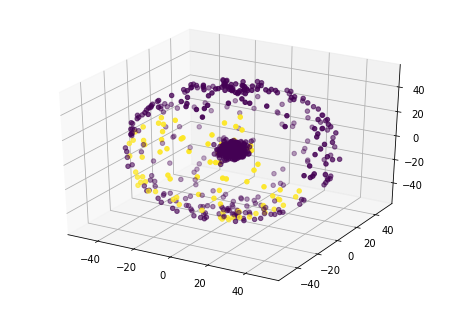


l1
linkage: complete
{'adjusted_mutual_info_score': 0.15889971446655077,
 'adjusted_rand_score': 0.080662610597615592,
 'completeness': 0.27026978951031772,
 'est_number_of_clusters': 2,
 'homogenity': 0.15966156079245025,
 'v_measure': 0.20073761263455603}


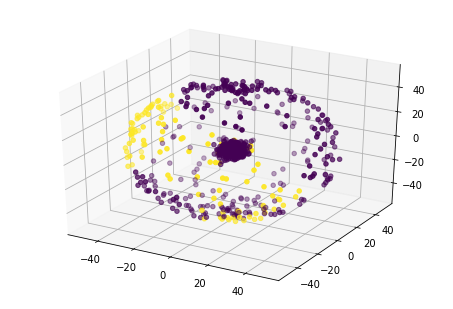


l2
linkage: average
{'adjusted_mutual_info_score': 0.17812042492975286,
 'adjusted_rand_score': 0.098626218186430442,
 'completeness': 0.28468240902897579,
 'est_number_of_clusters': 2,
 'homogenity': 0.17886455515562594,
 'v_measure': 0.21969550611196156}


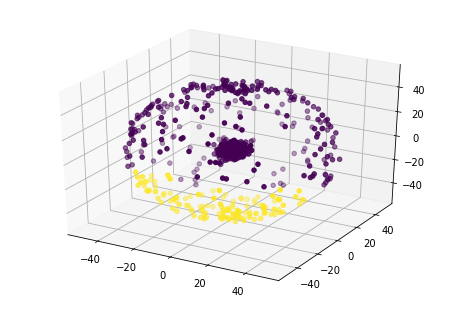


l2
linkage: complete
{'adjusted_mutual_info_score': 0.16206550003261144,
 'adjusted_rand_score': 0.08353119288930394,
 'completeness': 0.27265321423929345,
 'est_number_of_clusters': 2,
 'homogenity': 0.16282442208408213,
 'v_measure': 0.20388923946906878}


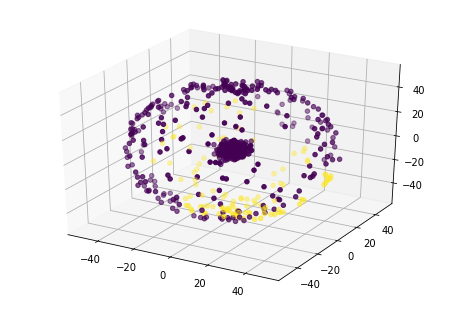


=== kmeans ===
cityblock
{'adjusted_mutual_info_score': 0.20801873708535848,
 'adjusted_rand_score': 0.12895636525412527,
 'completeness': 0.30692912282755064,
 'est_number_of_clusters': 2,
 'homogenity': 0.20873545110053299,
 'v_measure': 0.24848318906714226}


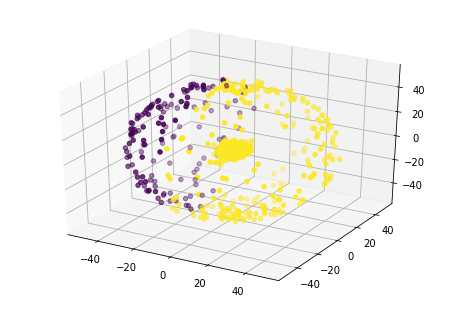


euclidean
{'adjusted_mutual_info_score': 0.25552644208538228,
 'adjusted_rand_score': 0.18206807775637832,
 'completeness': 0.34224323583575439,
 'est_number_of_clusters': 2,
 'homogenity': 0.25619981157127214,
 'v_measure': 0.29303591348443231}


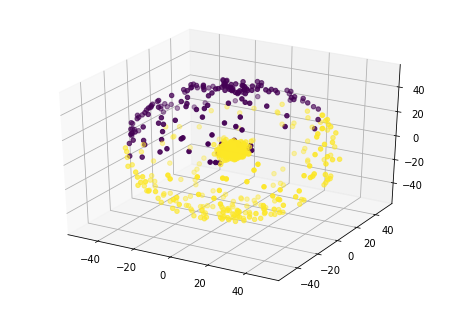


chebyshev
{'adjusted_mutual_info_score': 0.26470872976908699,
 'adjusted_rand_score': 0.19290664721232359,
 'completeness': 0.34909903582686463,
 'est_number_of_clusters': 2,
 'homogenity': 0.2653737423509373,
 'v_measure': 0.3015323733728445}


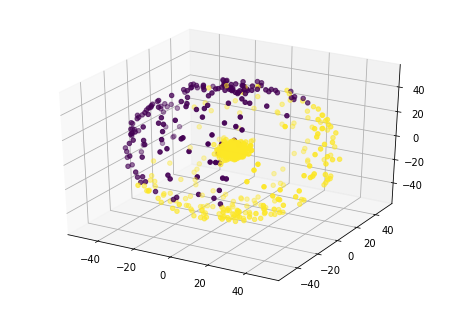


data/vehicle.arff <function visualze_vehicle at 0x7fc9b8d5dd90>
[('COMPACTNESS', 'REAL'), ('CIRCULARITY', 'REAL'), ('DISTANCE CIRCULARITY', 'REAL'), ('RADIUS RATIO', 'REAL'), ('PR.AXIS ASPECT RATIO', 'REAL'), ('MAX.LENGTH ASPECT RATIO', 'REAL'), ('SCATTER RATIO', 'REAL'), ('ELONGATEDNESS', 'REAL'), ('PR.AXIS RECTANGULARITY', 'REAL'), ('MAX.LENGTH RECTANGULARITY', 'REAL'), ('SCALED VARIANCE_MAJOR', 'REAL'), ('SCALED VARIANCE_MINOR', 'REAL'), ('SCALED RADIUS OF GYRATION', 'REAL'), ('SKEWNESS ABOUT_MAJOR', 'REAL'), ('SKEWNESS ABOUT_MINOR', 'REAL'), ('KURTOSIS ABOUT_MAJOR', 'REAL'), ('KURTOSIS ABOUT_MINOR', 'REAL'), ('HOLLOWS RATIO', 'REAL'), ('Class', ['opel', 'saab', 'bus', 'van'])]
=== ground truth ===


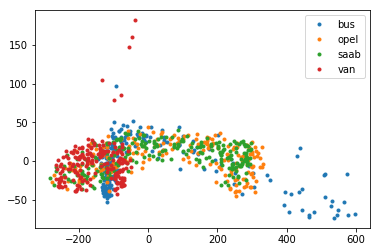

=== dbscan ===
euclidean
{'adjusted_mutual_info_score': 0.010272185889433199,
 'adjusted_rand_score': 3.9819127357950445e-05,
 'completeness': 0.25283234295355544,
 'est_number_of_clusters': 1,
 'homogenity': 0.011715729108518071,
 'v_measure': 0.02239377680454812}


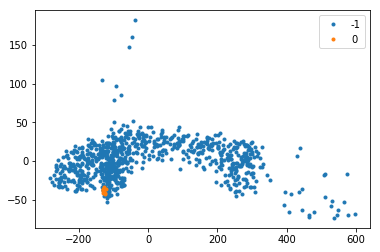


manhattan
{'adjusted_mutual_info_score': -6.4931870759361866e-16,
 'adjusted_rand_score': 0.0,
 'completeness': 1.0,
 'est_number_of_clusters': 0,
 'homogenity': -3.2049219756385899e-16,
 'v_measure': -6.4098439512771817e-16}


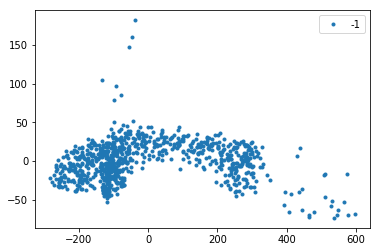


chebyshev
{'adjusted_mutual_info_score': 0.084550928691770721,
 'adjusted_rand_score': 0.029459081064081249,
 'completeness': 0.28030090906838889,
 'est_number_of_clusters': 2,
 'homogenity': 0.086984320607134652,
 'v_measure': 0.13276757228934041}


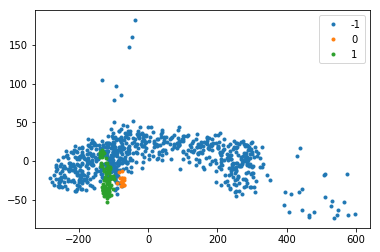


minkowski
{'adjusted_mutual_info_score': 0.010272185889433199,
 'adjusted_rand_score': 3.9819127357950445e-05,
 'completeness': 0.25283234295355544,
 'est_number_of_clusters': 1,
 'homogenity': 0.011715729108518071,
 'v_measure': 0.02239377680454812}


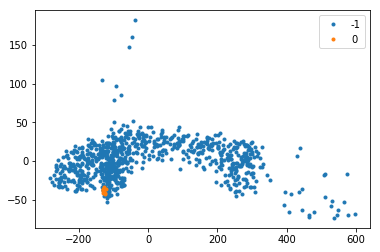


=== agglomerative ===
euclidean
linkage: average
{'adjusted_mutual_info_score': 0.12412054410733674,
 'adjusted_rand_score': 0.065408765378566366,
 'completeness': 0.23875213696228245,
 'est_number_of_clusters': 4,
 'homogenity': 0.1277342835691494,
 'v_measure': 0.16642817554471984}


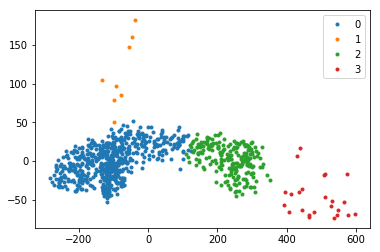


euclidean
linkage: complete
{'adjusted_mutual_info_score': 0.158712476101392,
 'adjusted_rand_score': 0.10713686549624543,
 'completeness': 0.19907348153475818,
 'est_number_of_clusters': 4,
 'homogenity': 0.16199732466781822,
 'v_measure': 0.17863184099600588}


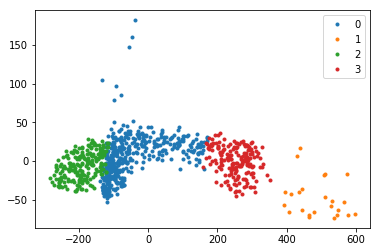


manhattan
linkage: average
{'adjusted_mutual_info_score': 0.14015455237041063,
 'adjusted_rand_score': 0.090278217514715584,
 'completeness': 0.25454528254288905,
 'est_number_of_clusters': 4,
 'homogenity': 0.14370159208465594,
 'v_measure': 0.18369792553054606}


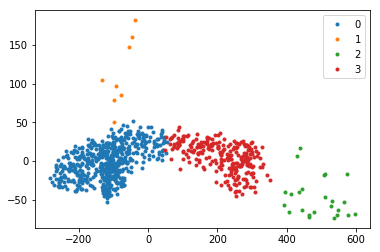


manhattan
linkage: complete
{'adjusted_mutual_info_score': 0.18036504982793453,
 'adjusted_rand_score': 0.11897731875877253,
 'completeness': 0.22678450986051635,
 'est_number_of_clusters': 4,
 'homogenity': 0.18356550690791493,
 'v_measure': 0.20289904623009311}


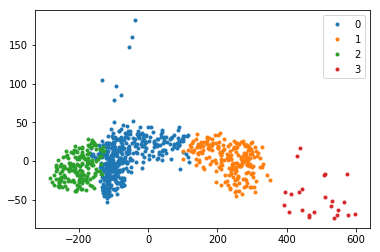


cosine
linkage: average
{'adjusted_mutual_info_score': 0.14670499452293559,
 'adjusted_rand_score': 0.10242145705818732,
 'completeness': 0.25994870064882991,
 'est_number_of_clusters': 4,
 'homogenity': 0.15022479473859546,
 'v_measure': 0.19041084144478948}


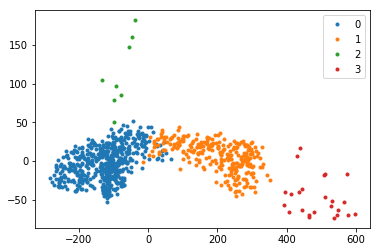


cosine
linkage: complete
{'adjusted_mutual_info_score': 0.13215237540310712,
 'adjusted_rand_score': 0.11914390664963452,
 'completeness': 0.1818065585117471,
 'est_number_of_clusters': 4,
 'homogenity': 0.13569363185182648,
 'v_measure': 0.15540143261451678}


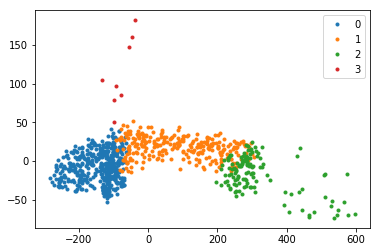


l1
linkage: average
{'adjusted_mutual_info_score': 0.14015455237041063,
 'adjusted_rand_score': 0.090278217514715584,
 'completeness': 0.25454528254288905,
 'est_number_of_clusters': 4,
 'homogenity': 0.14370159208465594,
 'v_measure': 0.18369792553054606}


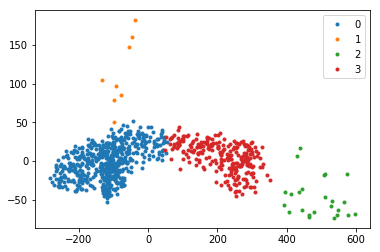


l1
linkage: complete
{'adjusted_mutual_info_score': 0.18036504982793453,
 'adjusted_rand_score': 0.11897731875877253,
 'completeness': 0.22678450986051635,
 'est_number_of_clusters': 4,
 'homogenity': 0.18356550690791493,
 'v_measure': 0.20289904623009311}


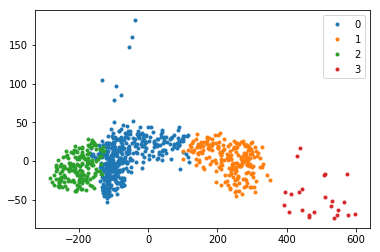


l2
linkage: average
{'adjusted_mutual_info_score': 0.12412054410733674,
 'adjusted_rand_score': 0.065408765378566366,
 'completeness': 0.23875213696228245,
 'est_number_of_clusters': 4,
 'homogenity': 0.1277342835691494,
 'v_measure': 0.16642817554471984}


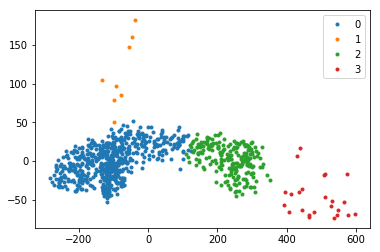


l2
linkage: complete
{'adjusted_mutual_info_score': 0.158712476101392,
 'adjusted_rand_score': 0.10713686549624543,
 'completeness': 0.19907348153475818,
 'est_number_of_clusters': 4,
 'homogenity': 0.16199732466781822,
 'v_measure': 0.17863184099600588}


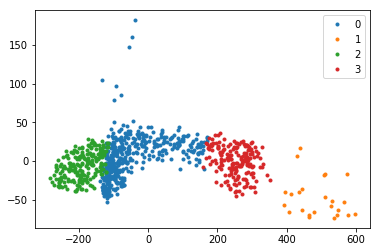


=== kmeans ===
cityblock
{'adjusted_mutual_info_score': 0.17414938156390766,
 'adjusted_rand_score': 0.11635132161137234,
 'completeness': 0.18819985593737801,
 'est_number_of_clusters': 4,
 'homogenity': 0.17733803222561326,
 'v_measure': 0.18260756653601279}


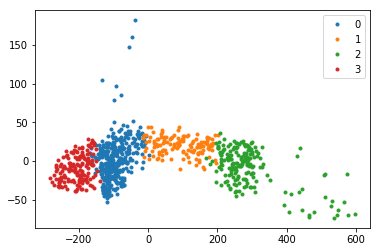


euclidean
{'adjusted_mutual_info_score': 0.1771110966403959,
 'adjusted_rand_score': 0.12070645178756825,
 'completeness': 0.19110382322877989,
 'est_number_of_clusters': 4,
 'homogenity': 0.18028832970643535,
 'v_measure': 0.18553859481484869}


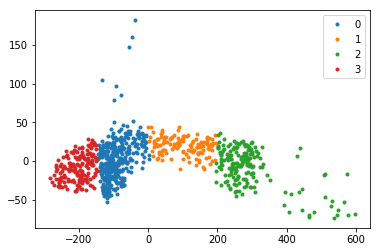


chebyshev
{'adjusted_mutual_info_score': 0.17264701637949684,
 'adjusted_rand_score': 0.11879023713486621,
 'completeness': 0.18615405641525357,
 'est_number_of_clusters': 4,
 'homogenity': 0.17584137504900585,
 'v_measure': 0.1808508196835642}


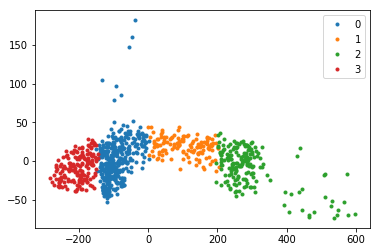

In [39]:
for path, visual in path_visual.items():
    print('===============================')
    print(path, visual)
    df = get_df(path)
    
    print('=== ground truth ===')
    visual(df, df['class'])
    
    visualizer = partial(visual, df)
    print('=== dbscan ===')
    eval_dbscan(df, visualizer)
    print('=== agglomerative ===')
    eval_agglomerative(df, visualizer, PATH_N_CLUST[path])
    print('=== kmeans ===')
    eval_kmeans(df, visualizer, PATH_N_CLUST[path])

In [12]:
# https://stackoverflow.com/questions/5529625/is-it-possible-to-specify-your-own-distance-function-using-scikit-learn-k-means

In [13]:
x_grid = np.linspace(-4.5, 3.5, 2)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
log_pdf = kde.score_samples(x)
pdf = np.exp(log_pdf)
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='test')


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: query data dimension must match training data dimension